# Support Vector Machine Linear classifier 

Here we implement a linear classified for CIFAR-10 dataset http://www.cs.toronto.edu/~kriz/cifar.html
Since it's a simple linear modelwe try to implement is ourself without relying on well-developed libraries like `PyTorch` or `TensorFlow`. 

In [58]:
# standart inputs
import matplotlib.pyplot as plt
import numpy as np

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2


%config InlineBackend.figure_format = 'retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Here we get the dataset
We download and extract the CIFAR-10 dataset.
No need to understand the following code.

In [2]:
import os
import requests
import tarfile
import sys

dataset_url = "http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
dataset_folder = "cifar-10"

if not os.path.exists(dataset_folder):
    filename = os.path.basename(dataset_url)
    # here we load the dataset from the url
    with open(filename, "wb") as f:
        with requests.get(dataset_url, allow_redirects=True, stream=True) as response:
            total_length = response.headers.get('content-length')
            if total_length is None: # no content length header
                f.write(response.content)
            else:
                dl = 0
                total_length = int(total_length)
                for data in response.iter_content(chunk_size=4*4096):
                    dl += len(data)
                    f.write(data)
                    done = int(50 * dl / total_length)
                    sys.stdout.write("\r Download in progress: [%s%d%%%s]" % ('/' * done, done*2,' ' * (50-done)) )    
                    sys.stdout.flush()
        
    # here we 'untar' it
    tar = tarfile.open(filename, "r:gz")
    tar.extractall()#path=dataset_folder+'/.')
    os.rename(tar.getnames()[0], dataset_folder)
    tar.close()
    
    #here we delete the .tarball
    os.remove(filename)

## Loading the data
So far no need to understand the following, but keep in mind that sometimes loading the data also take some effort. And this case is far from worst scenarios.

In [3]:
import time

# The data is split in 6 batches (including the testing one). We merge them all together.

dataset = {}

for batch in range(6):
    if batch != 5:
        filename = 'data_batch_%d' %(batch+1)
    else:
        filename = 'test_batch'
    ds_batch = np.load('%s/%s' %(dataset_folder, filename),
                       allow_pickle=True, encoding='latin1')

    for key in ['labels', 'data']:
        if key not in dataset:
            dataset[key] = ds_batch[key]
            dataset[key] = np.array(dataset[key])
        else:
            dataset[key] = np.concatenate((dataset[key], np.array(ds_batch[key])))

dataset['data'] = dataset['data'].reshape(dataset['data'].shape[0], 3, 32, 32).transpose(0,2,3,1).astype("float")

# normalize to 1
dataset['data'] /= 255.

In [4]:
dataset['labels'].shape, dataset['data'].shape

((60000,), (60000, 32, 32, 3))

In [5]:
# the labels are stored in numeric format
# we can use this dictionary to decode the labels

labels = {
    0: 'airplane',
    1: 'auto',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

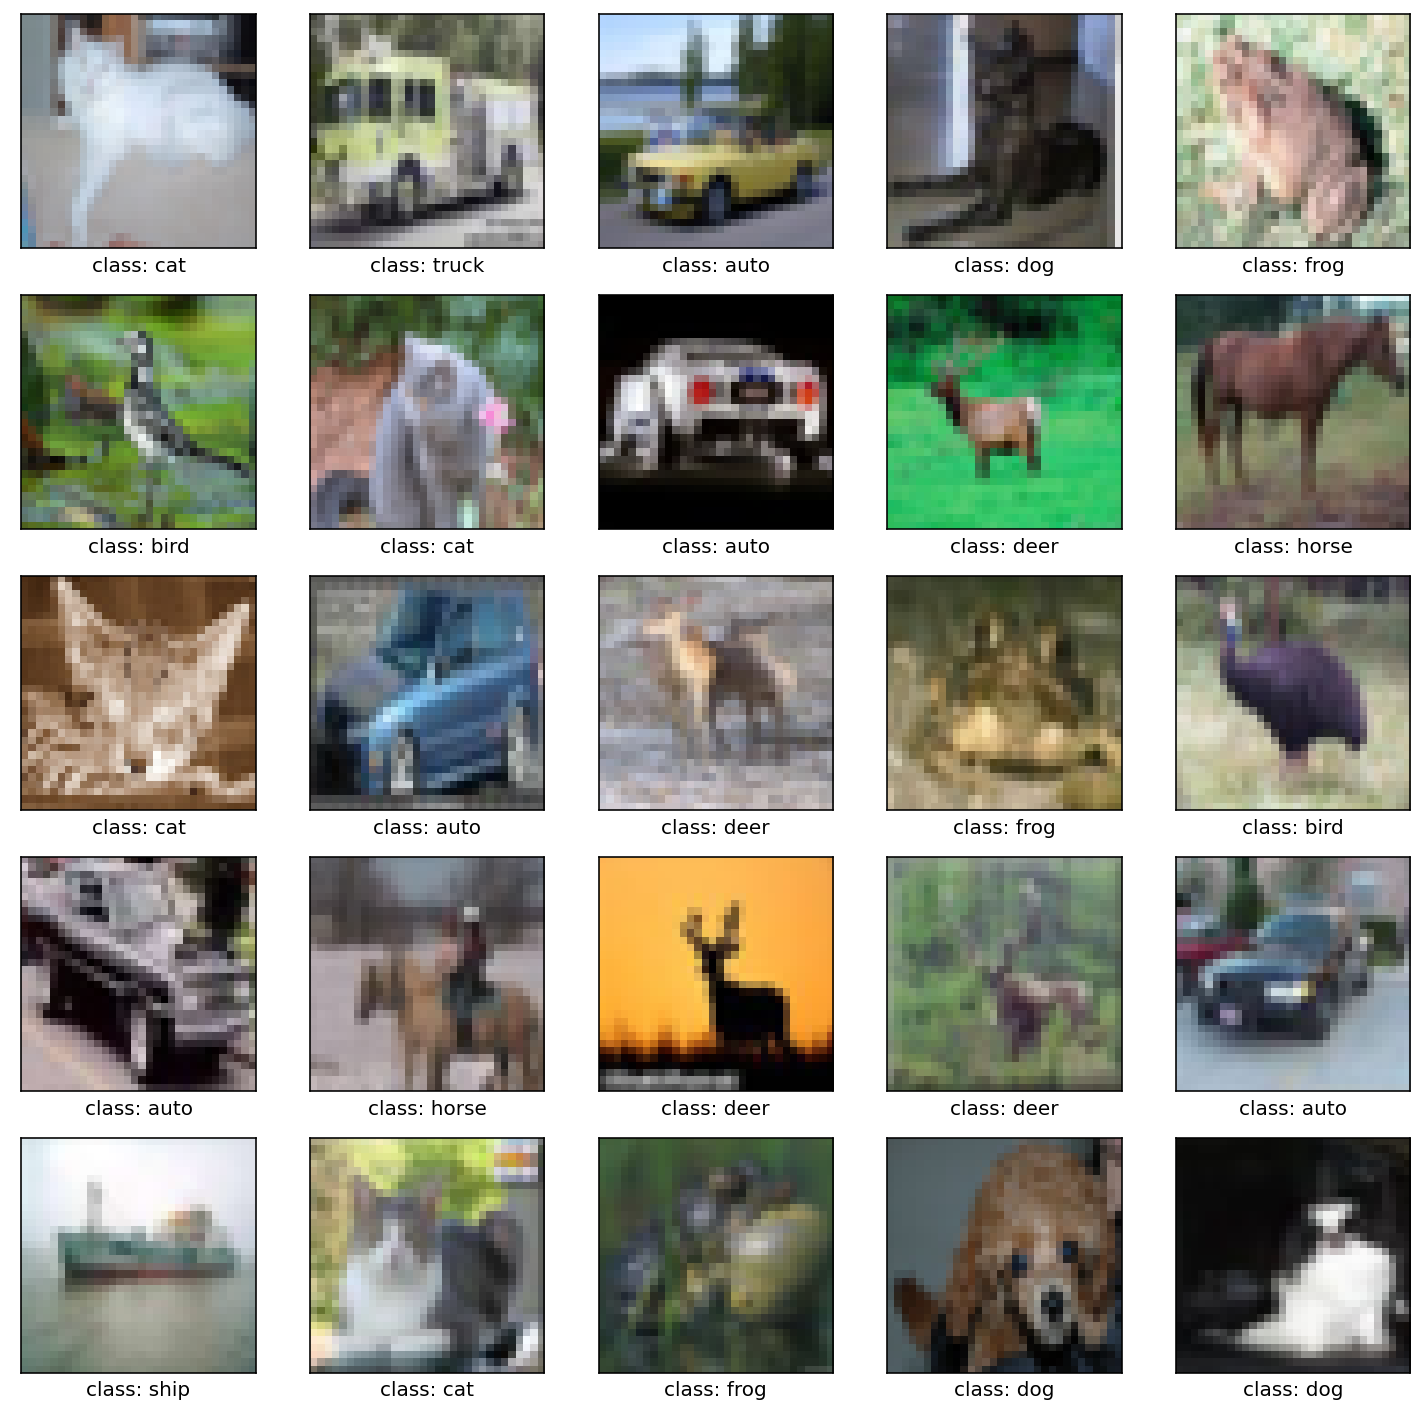

In [6]:
def plot_random_images(ds, n_images):
    # guess the size of the grid    
    size = np.sqrt(n_images)
    if size**2 != n_images:
        size += 1
    size = int(size)
    
    #initiate the figure size
    plt.figure(figsize=(2.5*size,2.5*size))
    
    # plot the images 
    for i in range(n_images):
        plt.subplot(size, size, i+1)
        
        # get a random image        
        rand_ind = np.random.randint(0,len(ds['labels']))
        
        plt.imshow(ds['data'][rand_ind])
        label_ind = ds['labels'][rand_ind]
        label = labels[label_ind]
        xlabel = "class: {0}".format(label)
        
        # show the classes as the label on the x-axis.
        plt.xlabel(xlabel)
    
        plt.xticks([])
        plt.yticks([])
        
    plt.show()
    return

plot_random_images(dataset, 25)

In [161]:
# split the dataset into training and testing
def split_data(data, test_ratio):
    data_len = len(data['data'])
    shuffled_indices = np.random.permutation(data_len)
    test_set_size = int(data_len * test_ratio)
    
    # use proper amount of elements
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    
    data_train = {}
    data_test = {}
    for key in data:
        data_train[key] = data[key][train_indices]
        data_test[key] = data[key][test_indices]
    return data_train, data_test

# here we use 1/10 of data for testing 
train, test = split_data(dataset, 0.1)

# and we take 1/10 of training data for validation
train, validate = split_data(train, 0.1)

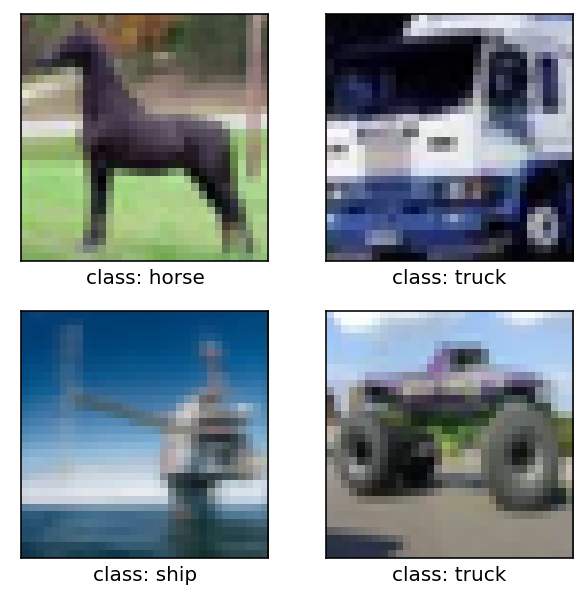

In [162]:
#here we check train images

plot_random_images(train, 4)

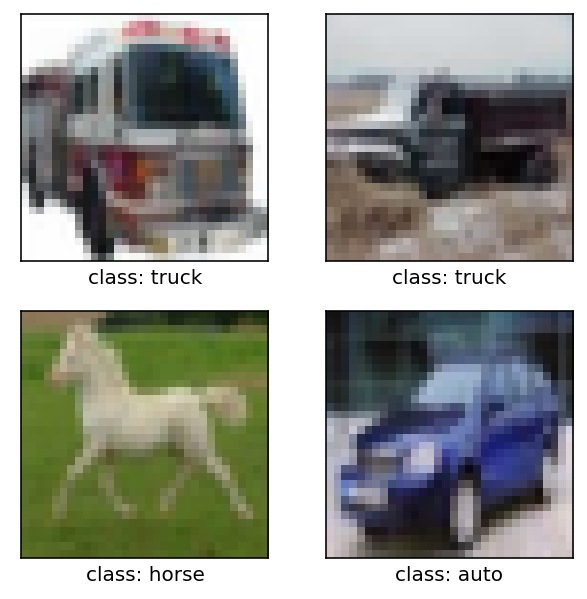

In [163]:
#here we check test images
plot_random_images(test, 4)

In [164]:
x = {'train' : train['data'], 'test' : train['data'], 'validate' : validate['data']}
y = {'train' : train['labels'], 'test' : train['labels'], 'validate' : validate['labels']}

for key in x:
    print(key, 'sample has shape', x[key].shape)

train sample has shape (48600, 32, 32, 3)
test sample has shape (48600, 32, 32, 3)
validate sample has shape (5400, 32, 32, 3)


## Usual preprocessing
as a part of usual preprocessing of data it is useful to substract the mean and normalize the data.
The data is already normalized, hence only the mean should be substracted.

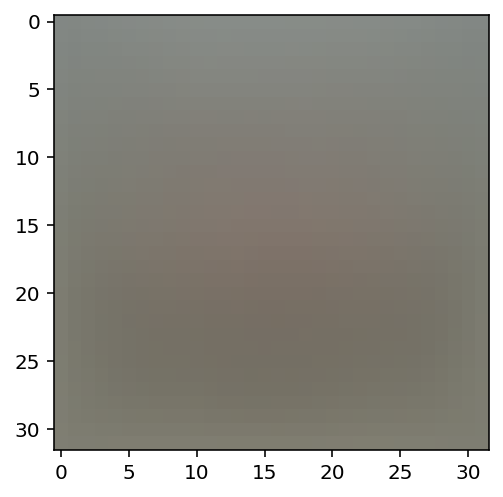

In [165]:
# here we visualize the mean
mean_image = np.mean(x['train'], axis=0)
plt.figure(figsize=(4,4))
plt.imshow(mean_image)
plt.show()

In [166]:
# ... and substract it from the data
for sample in x:
    x[sample] = x[sample] - mean_image

In [167]:
# now we flatten the data
for sample in x:
    # here we keep the first dimension of the sample (number of images in the sample)
    # and flatten the rest 32x32x3 to be 3072
    # -1 here is a dummy value that specifies that the rest indices should be flattened
    x[sample] = x[sample].reshape(x[sample].shape[0], -1)

## Bias vector trick
The bias vector $\vec b$ in <br>

<center>$\hat W \vec x + \vec b = \vec y$ </center>  <br>
can be incorporated in $\hat W$ by modifying the vector $\vec x$ <br>
<center> $\vec x ^\prime = (x_0,\, x_1,\, ..., x_{3072}, 1)$ </center>  <br>
hence
$$
\hat W ^\prime = \begin{pmatrix}
W_{1}^1 & ... & W_{3072}^1 & b^1\\
... & ... & ... & ... \\
W_{1}^10 & ... & W_{3072}^10 & b^{10}\\
\end{pmatrix}
$$
 and 
<center> $ \hat W^\prime \vec x^\prime = \vec y$ </center> 

In [168]:
for sample in x:
    x[sample] = np.hstack([x[sample], np.ones((x[sample].shape[0], 1))])
    print(sample, x[sample].shape)

train (48600, 3073)
test (48600, 3073)
validate (5400, 3073)


## SVM Classifier

Now we implement the svm loss and gradient. It's implemented in file **SVM/linear_svm.py**

In [141]:
# Evaluate the naive implementation of the loss we provided for you:
from SVM.linear_SVM import LinearSVM
import time

model = LinearSVM()

In [142]:
tic = time.time()
loss_log = model.train(x['train'], y['train'], n_epochs=500,
                             validate=True, x_val=x['validate'], y_val=y['validate'],
                             use_numpy=True, log_period=10)
toc = time.time()
print('loss: %e computed in %fs' % (loss_log[0], toc - tic))

iteration 0 / 500: loss 8.985521
validation accuracy 0.20
iteration 10 / 500: loss 7.735718
validation accuracy 0.24
iteration 20 / 500: loss 7.157835
validation accuracy 0.25
iteration 30 / 500: loss 6.408309
validation accuracy 0.27
iteration 40 / 500: loss 6.367693
validation accuracy 0.28
iteration 50 / 500: loss 6.303063
validation accuracy 0.29
iteration 60 / 500: loss 5.709351
validation accuracy 0.29
iteration 70 / 500: loss 5.765264
validation accuracy 0.30
iteration 80 / 500: loss 6.057205
validation accuracy 0.30
iteration 90 / 500: loss 5.901017
validation accuracy 0.30
iteration 100 / 500: loss 5.996536
validation accuracy 0.31
iteration 110 / 500: loss 5.345655
validation accuracy 0.31
iteration 120 / 500: loss 5.872518
validation accuracy 0.32
iteration 130 / 500: loss 5.263599
validation accuracy 0.32
iteration 140 / 500: loss 5.857689
validation accuracy 0.32
iteration 150 / 500: loss 5.166564
validation accuracy 0.32
iteration 160 / 500: loss 5.391522
validation accur

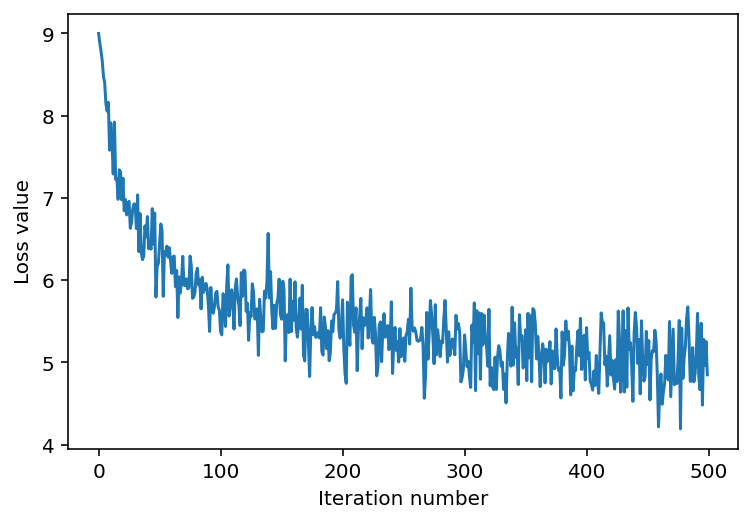

In [143]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [196]:
y_pred = model.predict(x['test'])

test_accuracy = np.mean(y['test'] == y_pred)

print("SVM linear classifier accuracy is %.2f%%" %(test_accuracy*100))

SVM linear classifier accuracy is 36.01%


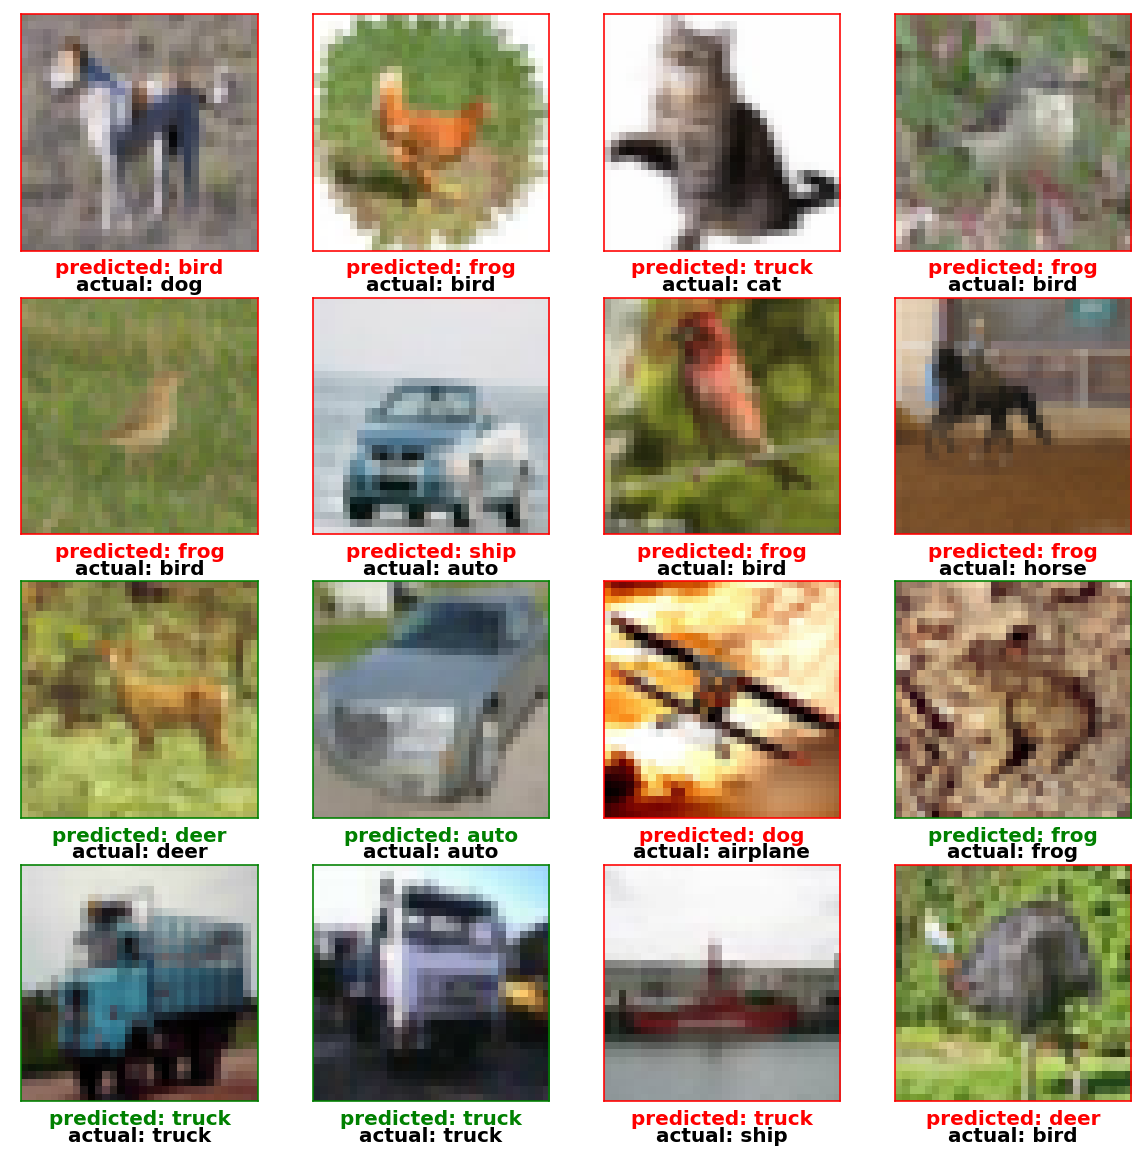

In [188]:
def plot_predictions(x,y, n_images, model):
    y_pred = model.predict(x[:n_images])
    
    # guess the size of the grid    
    size = np.sqrt(n_images)
    if size**2 != n_images:
        size += 1
    size = int(size)
    
    #initiate the figure size
    plt.figure(figsize=(2.5*size,2.5*size))
    
    # plot the images 
    for i in range(n_images):
        ax = plt.subplot(size, size, i+1)
        
        # get image
        img = x[i][:-1].reshape(32,32,3) + mean_image
        plt.imshow(img)
        label_ind = y[i]
        label_ind_pred = y_pred[i]
        label = labels[label_ind]
        label_pred = labels[label_ind_pred]
        c = "green" if label_pred == label else "red"
        plt.text(0.5, -0.1, "predicted: {0}".format(label_pred), color=c,
                ha='center', transform = ax.transAxes, weight='bold')
        plt.text(0.5, -0.17, "actual: {0}".format(label), color='black',
                ha='center', transform = ax.transAxes, weight='bold')
        
        plt.setp(ax.spines.values(), color=c)
        
        plt.xticks([])
        plt.yticks([])
        
    plt.show()
    return

plot_predictions(x['test'], y['test'], 16,model)